In [20]:
import numpy as np
import matplotlib as plt
import os 
import timeit
from scipy.stats import uniform
from numba import jit
import timeit

Define help function to compute the total stiffness

# Multilevel NN 

Let us now train a simplified NN compared to the fine models that takes as input parameter the output of the coarse model

First we have to create a dataset of the coarse sol for all the data we have 

In [6]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import load_model
# Import the function coarse_model
import sys
sys.path.append('../../tests/Xaccelerometer_geometric/models')
from coarse_model import *

# Local module imports
sys.path.append('../../src/SurrogateModeling')
sys.path.append('../../src/InverseProblems')
sys.path.append('../../src/utils')
from utils import * 

In [13]:
# Collecting traing and Testing Data
# Data preprocessing 
# Surrogate Model Configurations
CONFIGURATION_I = './config_I.json'
data_processor_I = preprocessing(CONFIGURATION_I)

X_train = data_processor_I.X_train
X_test = data_processor_I.X_test
y_train = data_processor_I.y_train
y_test = data_processor_I.y_test

In [14]:
coarse_y_train = []
coarse_y_test = []
for x in X_train:  
    coarse_y_train.append(coarse_model(x))
for x in X_test:
    coarse_y_test.append(coarse_model(x))

# Concatenate input parameters and coarse solutions
X_train_combined = np.concatenate((X_train, coarse_y_train), axis=1)
X_test_combined = np.concatenate((X_test, coarse_y_test), axis=1)


Now we can train the NN

In [15]:
Training = False

num_samples = 640
num_parameters = 3
num_coarse_values = 150

# Define the neural network model
model_LF_NN = Sequential([
       Dense(156, input_shape=(num_parameters + num_coarse_values,), activation='tanh'),  # First hidden layer with 32 neurons
    Dense(num_coarse_values)  # Output layer with 150 neurons (coarse solution)
])

if Training: 
   

     # Define the optimizer with an initial learning rate
    initial_learning_rate = 1e-3
    optimizer = Adam(learning_rate=initial_learning_rate)

    # Compile the model with the optimizer
    model_LF_NN.compile(optimizer=optimizer, loss='mean_squared_error')

    # Define a learning rate scheduler
    learning_rate_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

    # Train the model
    model_LF_NN.fit(X_train_combined, y_train, epochs = 30000, batch_size=32, validation_data= (X_test_combined, y_test), callbacks=learning_rate_scheduler)

    model_LF_NN.save('./models/model_LF_NN2.keras')

# Load the model
model_LF_NN = load_model('./models/model_LF_NN.keras')


/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


        Overetch,   Offset,   Thickness
The parameters used are: [ 0.230536 -0.068871 30.351452]
(150,) (3,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


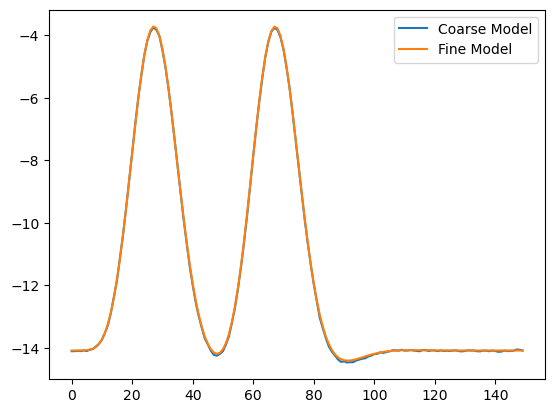

The parameters used are: [ 4.5057900e-01 -4.4200000e-04  2.9471304e+01]
(150,) (3,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


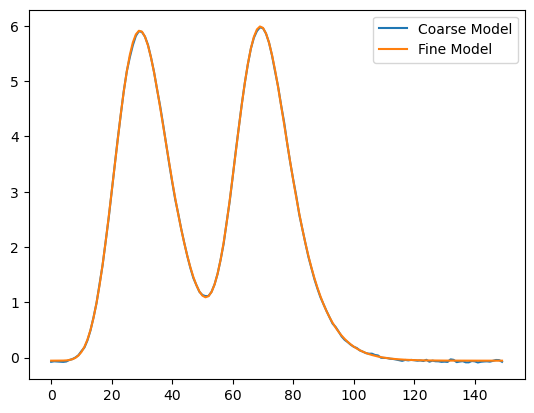

The parameters used are: [ 0.150782 -0.061468 30.962383]
(150,) (3,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


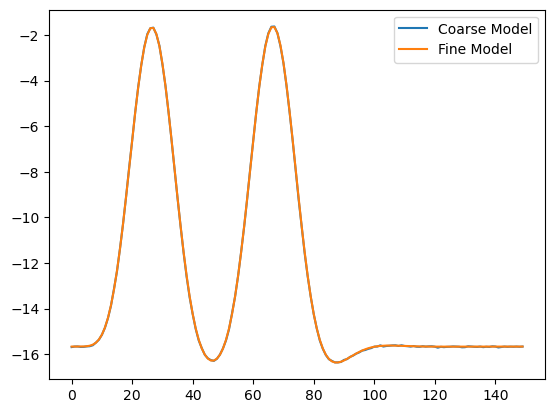

The parameters used are: [ 2.6249600e-01 -2.7814000e-02  2.9626475e+01]
(150,) (3,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


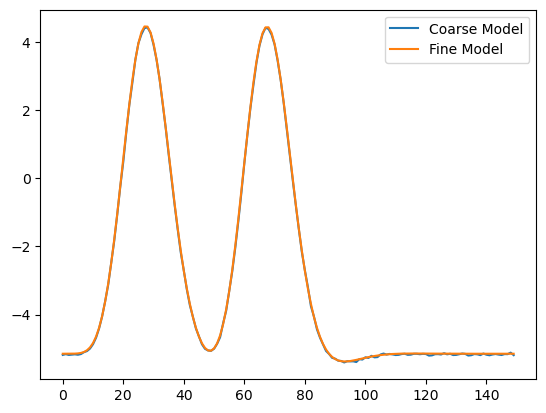

The parameters used are: [ 0.481828 -0.471044 29.200776]
(150,) (3,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


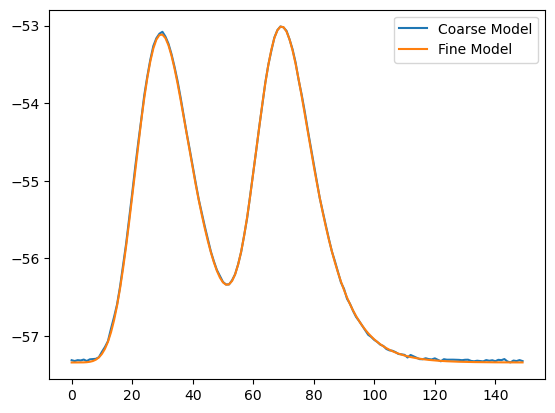

In [18]:
# Which sample of the training set do wou want to take as experimental input?
sample = [5,11, 22, 38, 154]

# Select a true sample for testing
x_true, y_true = X_test[sample], y_test[sample]
print('        Overetch,   Offset,   Thickness')
x_true

ratio = []
for index, x in enumerate(x_true):
    print('The parameters used are:' , x)
    rec_c = coarse_model(x)
    np.concatenate((x, coarse_model(x)))
    print(rec_c.shape, x.shape)
    res = model_LF_NN.predict( np.concatenate((x, coarse_model(x))).reshape(1,153)).reshape(150,)
    plt.plot(res)
    plt.plot(y_true[index])
    plt.legend(['Coarse Model', 'Fine Model'])
    plt.show()

load forward fine model 

In [23]:
# Initialize and load model
model_I = NN_Model()
model_I.load_model(data_processor_I.config['MODEL_PATH'])

# Define forward function
forward_model = create_forward_model_function(data_processor_I, model_I)

Compute the speed performance of the two models 

In [22]:
# Define parameters x
X = np.random.uniform(np.array([0.1, -0.5, 29.0]), np.array([0.5, 0.5, 31.0]), size=[1000,3])
# RMB: lower_bound= [0.1, -0.5, 29.0],  upper_bound=[0.5, 0.5, 31.0]

start_time = timeit.default_timer()
res_coarse = [model_LF_NN.predict( np.concatenate((X[i,:], coarse_model(X[i,:]))).reshape(1,153), verbose = False) for i in range(1000)]  
end_time = timeit.default_timer()

res_fine = [forward_model(X[i,:]) for i in range(1000)] 
end_time2 = timeit.default_timer()

print('Time Coarse', end_time-start_time)
print('Time fine', end_time2-end_time)


NameError: name 'forward_model' is not defined